#  TTS语音合成训练代码

### #0 导入nemo工具库及tts工具类

In [1]:
import nemo
import nemo.collections.tts as nemo_tts
from nemo.collections.tts.models import Tacotron2Model
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'nemo'

### #1.1 了解tacotron2.py训练脚本的代码结构

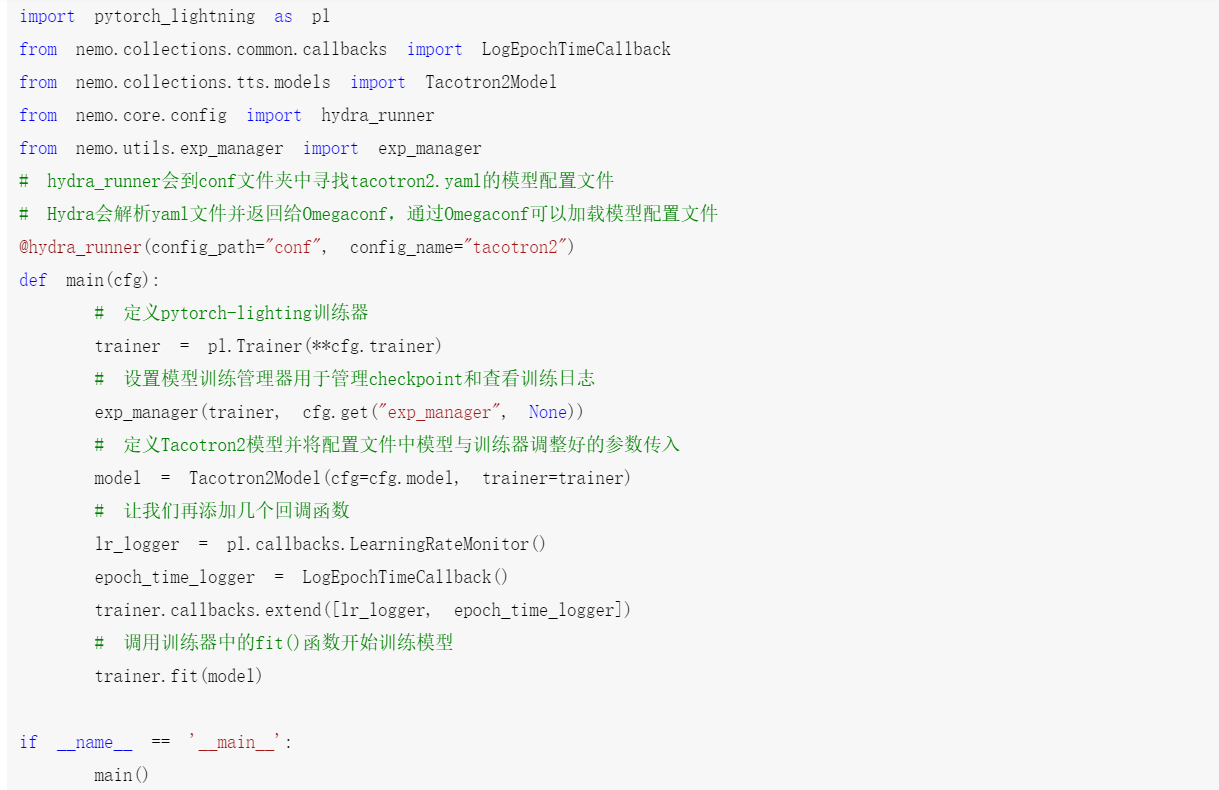

### #1.2 了解Tacotron2模型配置文件
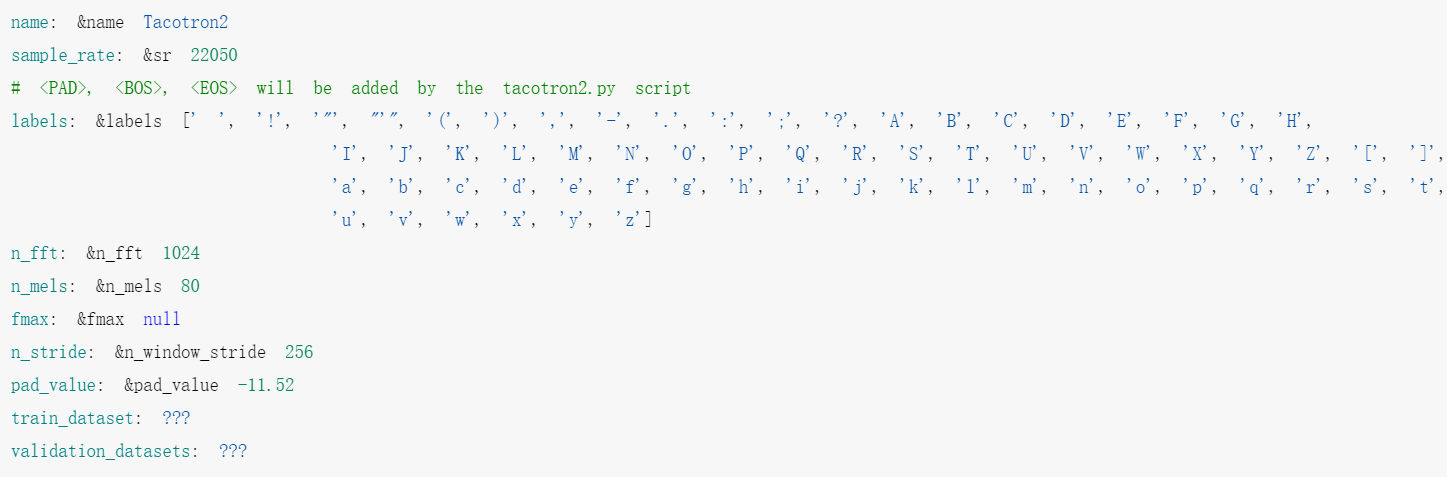、
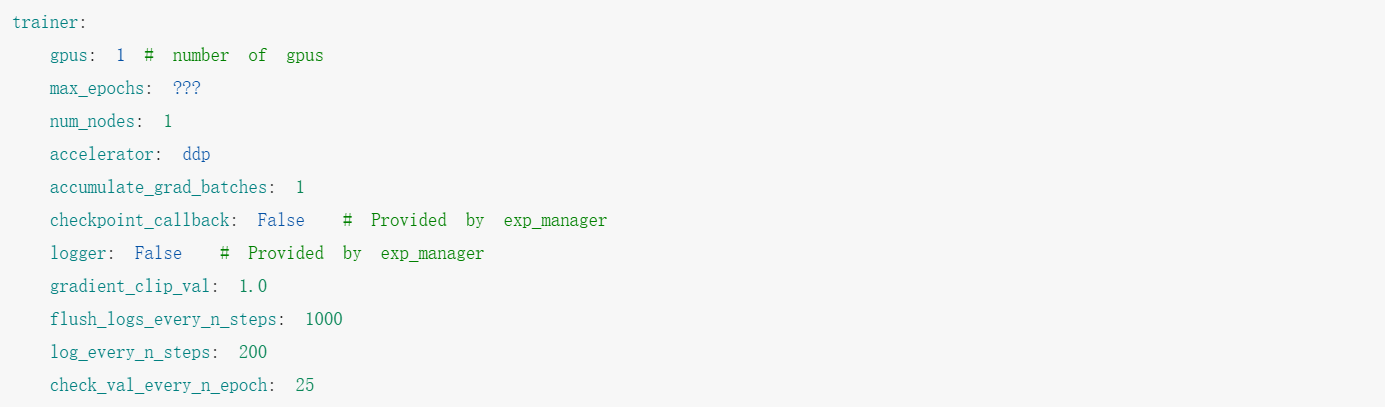

### #1.3 录制语音文件：
######  录制语音文件，文件类型需统一转换为wav格式，采样率建议在44100HZ 、单声道。
######  通过录音软件Audacity录制：Ubuntu系统安装=>sudo apt install audacity 
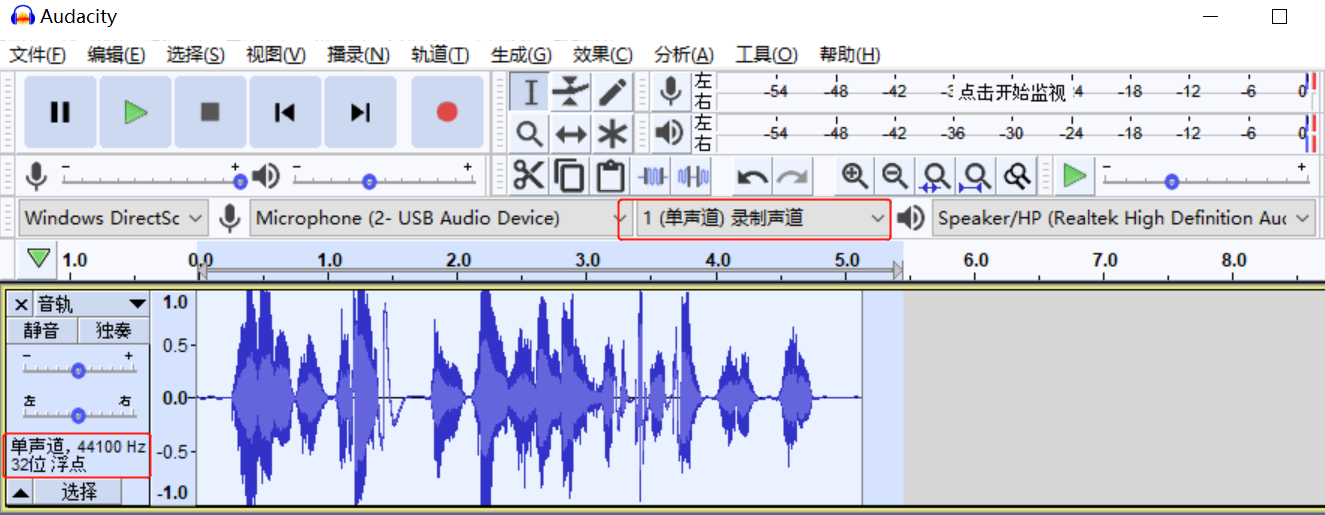

### #1.4制作语音数据清单格式摘要
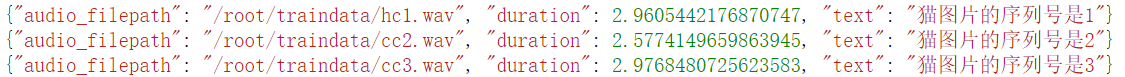

### #1.5通过librosa工具库获取语音时长

In [2]:
import librosa 
time = librosa.get_duration(filename="./traindata/tts_person3.wav")
print(time)

3.250793650793651


### #2.1 使用训练脚本设置相关参数进行训练：
#### 指定训练集路径：train_dataset=/root/manifest/train_manifest_tts.json
#### 指定验证集路径：validation_datasets=/root/manifest/test_manifest_tts.json
#### 指定训练次数：trainer.max_epochs=1500

In [4]:
import pytorch_lightning as pl
! HYDRA_FULL_ERROR=1 python tacotron2.py train_dataset=./train_manifest_tts.json validation_datasets=./test_manifest_tts.json trainer.max_epochs=1500 trainer.accelerator=null trainer.check_val_every_n_epoch=1

Traceback (most recent call last):
  File "tacotron2.py", line 16, in <module>
    import pytorch_lightning as pl
ModuleNotFoundError: No module named 'pytorch_lightning'


###  #2.2在指定路径中加载训练后的Tacotron2模型用来生成文字对应的频谱图

In [3]:
model = Tacotron2Model.restore_from("/root/nemo_experiments/Tacotron2/2021-11-02_21-24-58/checkpoints/Tacotron2.nemo")

[NeMo W 2021-11-05 14:42:00 modelPT:130] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_text.AudioToCharDataset
      manifest_filepath: /root/manifest/train_manifest_tts.json
      max_duration: null
      min_duration: 0.1
      trim: false
      int_values: false
      normalize: true
      sample_rate: 22050
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 48
      num_workers: 4
    
[NeMo W 2021-11-05 14:42:00 modelPT:137] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_text.AudioToCharDataset
  

[NeMo I 2021-11-05 14:42:00 features:262] PADDING: 16
[NeMo I 2021-11-05 14:42:00 features:279] STFT using torch
[NeMo I 2021-11-05 14:42:04 save_restore_connector:143] Model Tacotron2Model was successfully restored from /root/nemo_experiments/Tacotron2/2021-11-02_21-24-58/checkpoints/Tacotron2.nemo.


### #2.3加载melgan声码器模型用于将频谱图转化成语音文件

In [4]:
vocoder = nemo_tts.models.MelGanModel.restore_from("tts_melgan.nemo")

[NeMo W 2021-11-05 14:42:08 modelPT:130] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_train.json
      max_duration: null
      min_duration: 0.75
      n_segments: 16384
      trim: false
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2021-11-05 14:42:08 modelPT:137] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_val.jso

[NeMo I 2021-11-05 14:42:08 features:262] PADDING: 0
[NeMo I 2021-11-05 14:42:08 features:279] STFT using torch
[NeMo I 2021-11-05 14:42:08 features:281] STFT using exact pad
[NeMo I 2021-11-05 14:42:09 save_restore_connector:143] Model MelGanModel was successfully restored from /root/tts_melgan.nemo.


### #2.4 输入需要进行语音合成的文字生成对应的频谱图

输入需要进行语音合成的文字
猫图片的序列号是1


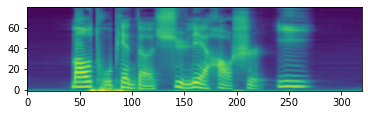

In [5]:
print(f"输入需要进行语音合成的文字")
text = input()
tokens = model.parse(text)
spectrogram = model.generate_spectrogram(tokens = tokens)
%matplotlib inline
imshow(spectrogram.cpu().detach().numpy()[0,...], origin="lower")
plt.show()

### #2.5 通过声码器将频谱图转化为语音音频并播放

In [6]:
audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)
import IPython
IPython.display.Audio(audio.to('cpu').detach().numpy(), rate=22050)

### #3.1将合成出来的语音写出磁盘用于对比测试

In [8]:
import scipy.io.wavfile as wavf
audio=audio.to('cpu').detach().numpy()
wavf.write('out.wav', 22050, audio.T)

### #3.2 通过对比原始语音音频与合成的语音音频得除PESQ分值（客观可懂性评价标准，是MOS主观平均评分的客观映射）

In [13]:
from pesq import pesq
#pesq为客观音频可懂性评价标准
rate,ref = wavf.read("/root/testdata/cat_t.wav")#读取groud truth原始音频
rate, deg = wavf.read("out.wav")#读取合成音频
print(pesq(16000, ref, deg, 'wb')) #pesq只支持16000Hz的音频评估，这里需要进行降采样至16000Hz进行对比评估

1.7998619079589844
